In [12]:
import json
import math
import numpy as np
import pandas as pd
from data_loading import ChatHighlightData
import utils
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
import re

In [3]:
# pre-computed meta-data for the matches in the training set
with open("data/analysis/MatchesMeta_train.json", "r") as in_file:
    matches_meta = json.load(in_file)

should be 133, but is 128 because highlight annotations of some matches are missing:

* nalcs_w5d2_C9_TMS_g1 https://www.youtube.com/watch?v=uh0npPZsUUc (typo in team name)
* nalcs_w6d3_IMT_NV_g1 https://www.youtube.com/watch?v=U9msQYsWcOo
* nalcs_w6d2_FOX_C9_g1 https://www.youtube.com/watch?v=JF2o7xIg0no
* nalcs_w6d2_FLY_NV_g1 https://www.youtube.com/watch?v=TyZRsAT6P5k
* nalcs_w5d2_C9_TMS_g3 https://www.youtube.com/watch?v=xtNhxrG2U5A

The chat for the matches is present


Fu et. al report 

|tournament|train|val|test|total|
|-----|--:|-:|-:|--:|
|NALCS|128|40|50|218|
|LMS|57|18|28|103|


In [23]:
len(matches_meta)

128

In [7]:
list(matches_meta[list(matches_meta.keys())[0]].keys())

['highlight_spans',
 'highlight_lengths',
 'highlight_count',
 'highlight_avg_len',
 'highlights',
 'chat_message_density',
 'chat_emote_density',
 'chat_copypasta_density']

### Shortest highlight

In [60]:
matches_hl_lengths = list()

for name, match_data in matches_meta.items():
    if match_data["highlight_lengths"]:
        for i, (hl_start, hl_end) in enumerate(match_data["highlight_spans"]):
            matches_hl_lengths.append((name, i,hl_start, hl_end, hl_end - hl_start, (hl_end - hl_start)/30))
    else:
        print("no highlights in match: ", name)

no highlights in match:  nalcs_w8d3_TSM_FOX_g1


In [50]:
matches_hl_lengths_sorted = sorted(matches_hl_lengths, key=lambda x: x[-1])

print("shortest highlight:", matches_hl_lengths_sorted[0])
print("longest highlight:", matches_hl_lengths_sorted[-1])

shortest highlight: ('nalcs_w5d2_TL_DIG_g3', 55729, 55737, 8, 0.26666666666666666)
longest highlight: ('nalcs_w4d1_C9_TL_g3', 42455, 50299, 7844, 261.46666666666664)


In [52]:
min_len_match_name = matches_hl_lengths_sorted[0][0]

for i, (start, end) in enumerate(matches_meta[min_len_match_name]["highlight_spans"]):
    print(i+1, start, end, end-start, round((end-start)/30, 2))

1 9106 9385 279 9.3
2 15309 16009 700 23.33
3 27923 28503 580 19.33
4 31221 31590 369 12.3
5 37273 37823 550 18.33
6 46649 47066 417 13.9
7 51135 52495 1360 45.33
8 52883 53152 269 8.97
9 55308 55657 349 11.63
10 55729 55737 8 0.27
11 58598 59188 590 19.67
12 61916 63029 1113 37.1
13 67418 70760 3342 111.4


In [64]:
df = pd.DataFrame(matches_hl_lengths, columns=["match_name", "hl_index_in_match", "hl_start_frame", "hl_end_frame", "hl_duration_frames", "hl_duration_secs"])
df.sort_values(["hl_duration_frames"]).head(50)

,match_name,hl_index_in_match,hl_start_frame,hl_end_frame,hl_duration_frames,hl_duration_secs
783,nalcs_w5d2_TL_DIG_g3,9,55729,55737,8,0.266667
1567,nalcs_w5d2_CLG_IMT_g3,8,51933,51952,19,0.633333
580,nalcs_w1d3_TSM_IMT_g1,20,105641,105660,19,0.633333
666,nalcs_w9d3_CLG_NV_g3,16,83516,83536,20,0.666667
159,nalcs_w2d3_C9_CLG_g3,18,97418,97447,29,0.966667
1394,nalcs_w2d3_P1_TL_g1,13,65226,65255,29,0.966667
359,nalcs_w1d3_NV_CLG_g1,14,79672,79710,38,1.266667
1515,nalcs_w3d2_C9_NV_g1,6,55160,55200,40,1.333333
1049,nalcs_w1d1_FOX_P1_g1,12,75469,75517,48,1.600000
1365,nalcs_w2d2_P1_NV_g1,8,75516,75575,59,1.966667


looks like there is screen tearing [nalcs_w5d2_TL_DIG_g3 at the screen tearing location](https://youtu.be/zWdtNCGZDRM?t=293) could be a possible reason for the 9 frame highlight

may wanna filter that out

### Matches without highlights
Looking at nalcs_w8d3_TSM_FOX_g1, nalcs_w8d3_TSM_FOX_g1nalcs_w8d3_TSM_FOX_g2

In [19]:
gold_data_TSM_FOX_g1 = np.load("data/gt/nalcs_w8d3_TSM_FOX_g1.npy")
gold_data_TSM_FOX_g2 = np.load("data/gt/nalcs_w8d3_TSM_FOX_g2.npy")

In [21]:
print(gold_data_TSM_FOX_g1.sum())
print(gold_data_TSM_FOX_g2.sum())

0
0


There are actually no detected highlights in this match, however, on youtube we find a video. The naming conventions are not upheld on the youtube channel, so it may have been missed when crawling:

* [nalcs_w8d3_TSM_FOX_g1](https://www.youtube.com/watch?v=onMKVMeXbI4)
* [nalcs_w8d3_TSM_FOX_g2](https://www.youtube.com/watch?v=ZoC3qcv6Gr0)

## Distribution of message densities in matches

In [3]:
chd = ChatHighlightData()
chd.load_data(file_identifier="nalcs*")

In [4]:
data_totals = chd.get_data_totals()

In [5]:
data_totals["chat_message_count"]/(data_totals["video_length_secs"]/60)

174.60866602711147

characteristics of message counts per video where one __video__ is one __match__ in the tournament

In [76]:
def determine_split(m):
    if re.match("nalcs_w.*_g1", m):
        return "g1"
    elif re.match("nalcs_w.*_g2", m):
        return "g2"
    elif re.match("nalcs_w.*_g3", m):
        return "g3"

In [54]:
match = re.match("nalcs_w.*_g[13]", "nalcs_w5d3_TL_CLG_g3")

In [55]:
print(match is None)

False


In [77]:
msg_counts =  list()
video_lengths = list()
split = list()
for match, data in chd.chat.items():
    msg_counts.append(len(utils.unpack_messages(data)))
    video_lengths.append(len(data))
    split.append(determine_split(match))

In [16]:
np.std(msg_counts)

5364.576250815363

In [17]:
video_lens_mins = np.asarray(video_lengths)/30/60

In [18]:
video_msg_per_min = np.asarray(msg_counts)/video_lens_mins

In [19]:
np.mean(video_msg_per_min), np.std(video_msg_per_min), video_msg_per_min.min(), video_msg_per_min.max()

(173.48236005998083, 105.00346365170638, 16.457191964765283, 492.3325512417548)

In [20]:
video_lens_mins.mean(), video_lens_mins.std(), video_lens_mins.min(), video_lens_mins.max()

(45.53952854230378, 8.710836916472084, 30.308888888888887, 88.46499999999999)

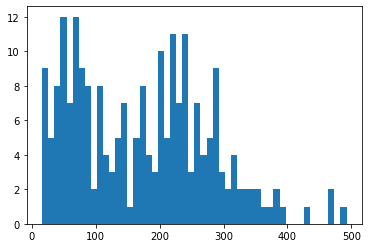

In [70]:
plt.hist(video_msg_per_min, bins=50)
plt.show()

In [78]:
vmpm_g1 = [vmpm for vmpm, s in zip(video_msg_per_min, split) if s == "trn"]
vmpm_g2 = [vmpm for vmpm, s in zip(video_msg_per_min, split) if s == "val"]
vmpm_g3 = [vmpm for vmpm, s in zip(video_msg_per_min, split) if s == "tst"]

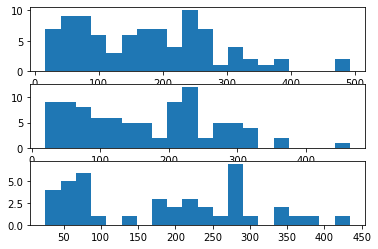

In [79]:
figure, axis = plt.subplots(3,1)
for i, s in enumerate([vmpm_g1, vmpm_g2, vmpm_g3]):
    axis[i].hist(s, bins=20)
plt.show()

We see two distributions in the message_per minute measure (maybe group stage and finals stage?) => TODO: check twitch streams literature reference for this

Follow this guide to get the bi-modal distribution out: https://machinelearningmastery.com/probability-density-estimation/

In [125]:
def model_from_samples(s, b):
    # fit density
    sample = s.reshape((-1, 1))
    m = KernelDensity(bandwidth=b, kernel='gaussian')
    return m.fit(s)

In [126]:
def plot_model(v, model):
    # sample probabilities for a range of outcomes
    values = np.arange(0,v.max(),1)
    values = values.reshape((-1, 1))
    probabilities = m.score_samples(values)
    probabilities = np.exp(probabilities)
    
    # plot the histogram and pdf
    plt.hist(v, bins=50, density=True)
    plt.plot(values[:], probabilities)
    plt.show()

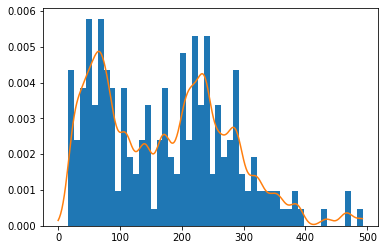

In [127]:
vals = video_msg_per_min.reshape((-1,1))
m = model_from_samples(vals, 20)
plot_model(vals, m)

(array([ 7., 26., 44., 40., 33., 20., 21., 24., 16.,  9., 17., 18., 30.,
        41., 34., 16., 22., 20., 18.,  8.,  5.,  6.,  5.,  7.,  3.,  1.,
         1.,  1.,  3.,  4.]),
 array([  3.59039142,  19.63729371,  35.684196  ,  51.73109829,
         67.77800057,  83.82490286,  99.87180515, 115.91870744,
        131.96560972, 148.01251201, 164.0594143 , 180.10631659,
        196.15321887, 212.20012116, 228.24702345, 244.29392574,
        260.34082802, 276.38773031, 292.4346326 , 308.48153489,
        324.52843717, 340.57533946, 356.62224175, 372.66914404,
        388.71604632, 404.76294861, 420.8098509 , 436.85675319,
        452.90365547, 468.95055776, 484.99746005]),
 <BarContainer object of 30 artists>)

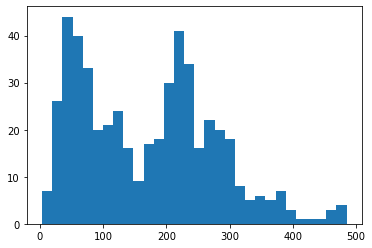

In [140]:
plt.hist(m.sample(500), bins=30)